In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.metrics import r2_score


In [11]:
df = pd.read_csv("forecasting_ready_1.csv")
df["Date"] = pd.to_datetime(df["Date"])

sku = df["SKU_ID"].unique()[0]

sku_df = df[df["SKU_ID"] == sku].sort_values("Date")

In [12]:
def create_features(data, lags=[1,7,14,30]):
    df_feat = data.copy()

    for lag in lags:
        df_feat[f"lag_{lag}"] = df_feat["Units_Sold"].shift(lag)

    # rolling stats
    df_feat["roll_mean_7"] = df_feat["Units_Sold"].rolling(7).mean()
    df_feat["roll_std_7"] = df_feat["Units_Sold"].rolling(7).std()

    df_feat = df_feat.dropna()

    return df_feat

df_feat = create_features(sku_df[["Date","Units_Sold"]])

In [13]:
X = df_feat.drop(columns=["Date","Units_Sold"])
y = df_feat["Units_Sold"]

In [14]:
split = len(X) - 60

X_train, X_test = X.iloc[:split], X.iloc[split:]
y_train, y_test = y.iloc[:split], y.iloc[split:]

dates_test = df_feat["Date"].iloc[split:]

In [15]:
model = XGBRegressor(
    n_estimators=300,
    learning_rate=0.05,
    max_depth=5,
    subsample=0.8,
    colsample_bytree=0.8,
    objective="reg:squarederror"
)

model.fit(X_train, y_train)

,"objective objective: typing.Union[str, xgboost.sklearn._SklObjWProto, typing.Callable[[typing.Any, typing.Any], typing.Tuple[numpy.ndarray, numpy.ndarray]], NoneType]Specify the learning task and the corresponding learning objective or a customobjective function to be used.For custom objective, see :doc:`/tutorials/custom_metric_obj` and:ref:`custom-obj-metric` for more information, along with the end note forfunction signatures.",'reg:squarederror'
,"base_score base_score: typing.Union[float, typing.List[float], NoneType]The initial prediction score of all instances, global bias.",None
,booster,None
,"callbacks callbacks: typing.Optional[typing.List[xgboost.callback.TrainingCallback]]List of callback functions that are applied at end of each iteration.It is possible to use predefined callbacks by using:ref:`Callback API `... note:: States in callback are not preserved during training, which means callback objects can not be reused for multiple training sessions without reinitialization or deepcopy... code-block:: python for params in parameters_grid: # be sure to (re)initialize the callbacks before each run callbacks = [xgb.callback.LearningRateScheduler(custom_rates)] reg = xgboost.XGBRegressor(**params, callbacks=callbacks) reg.fit(X, y)",None
,colsample_bylevel colsample_bylevel: typing.Optional[float]Subsample ratio of columns for each level.,None
,colsample_bynode colsample_bynode: typing.Optional[float]Subsample ratio of columns for each split.,None
,colsample_bytree colsample_bytree: typing.Optional[float]Subsample ratio of columns when constructing each tree.,0.8
,"device device: typing.Optional[str].. versionadded:: 2.0.0Device ordinal, available options are `cpu`, `cuda`, and `gpu`.",None
,"early_stopping_rounds early_stopping_rounds: typing.Optional[int].. versionadded:: 1.6.0- Activates early stopping. Validation metric needs to improve at least once in every **early_stopping_rounds** round(s) to continue training. Requires at least one item in **eval_set** in :py:meth:`fit`.- If early stopping occurs, the model will have two additional attributes: :py:attr:`best_score` and :py:attr:`best_iteration`. These are used by the :py:meth:`predict` and :py:meth:`apply` methods to determine the optimal number of trees during inference. If users want to access the full model (including trees built after early stopping), they can specify the `iteration_range` in these inference methods. In addition, other utilities like model plotting can also use the entire model.- If you prefer to discard the trees after `best_iteration`, consider using the callback function :py:class:`xgboost.callback.EarlyStopping`.- If there's more than one item in **eval_set**, the last entry will be used for early stopping. If there's more than one metric in **eval_metric**, the last metric will be used for early stopping.",None
,enable_categorical enable_categorical: boolSee the same parameter of :py:class:`DMatrix` for details.,False
,"eval_metric eval_metric: typing.Union[str, typing.List[typing.Union[str, typing.Callable]], typing.Callable, NoneType].. versionadded:: 1.6.0Metric used for monitoring the training result and early stopping. It can be astring or list of strings as names of predefined metric in XGBoost (See:doc:`/parameter`), one of the metrics in :py:mod:`sklearn.metrics`, or anyother user defined metric that looks like `sklearn.metrics`.If custom objective is also provided, then custom metric should implement thecorresponding reverse link function.Unlike the `scoring` parameter commonly used in scikit-learn, when a callableobject is provided, it's assumed to be a cost function and by default XGBoostwill minimize the result during early stopping.For advanced usage on Early stopping like directly choosing to maximize insteadof minimize, see :py:obj:`xgboost.callback.EarlyStopping`.See :doc:`/tutorials/custom_metric_obj` and :ref:`custom-obj-metric` for moreinformation... code-block:: python from sklearn.datasets import load_diabetes 

In [16]:
pred = model.predict(X_test)

In [17]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np

actual = y_test.values
predicted = pred

mae = mean_absolute_error(actual, predicted)
rmse = np.sqrt(mean_squared_error(actual, predicted))
mape = np.mean(np.abs((actual - predicted) / actual)) * 100
r2 = r2_score(actual, predicted)


accuracy = 100 - mape   # optional (not standard but easy to present)

print("XGBoost Model Performance")
print("-------------------------")
print(f"MAE   : {mae:.2f}")
print(f"RMSE  : {rmse:.2f}")
print(f"MAPE  : {mape:.2f}%")
print(f"Accuracy: {accuracy:.2f}%")
print(f"R2 Score : {r2:.3f}")



XGBoost Model Performance
-------------------------
MAE   : 10.57
RMSE  : 12.90
MAPE  : 13.25%
Accuracy: 86.75%
R2 Score : 0.283


In [8]:
mae = mean_absolute_error(y_test, pred)
rmse = np.sqrt(mean_squared_error(y_test, pred))
mape = np.mean(np.abs((y_test - pred) / y_test)) * 100

print(f"MAE  : {mae:.2f}")
print(f"RMSE : {rmse:.2f}")
print(f"MAPE : {mape:.2f}%")

MAE  : 10.57
RMSE : 12.90
MAPE : 13.25%


• Learned patterns from ~300 past days
• Predicted next 60 days of demand
• Compared prediction vs actual

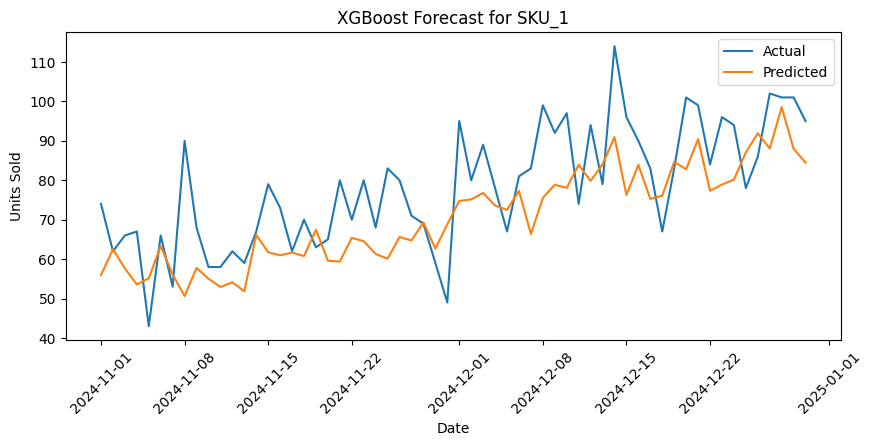

In [9]:
plt.figure(figsize=(10,4))
plt.plot(dates_test, y_test.values, label="Actual")
plt.plot(dates_test, pred, label="Predicted")
plt.legend()
plt.xlabel("Date")
plt.ylabel("Units Sold")
plt.title(f"XGBoost Forecast for {sku}")
plt.xticks(rotation=45)
plt.show()

In [10]:
X = df_feat.drop(columns=["Date","Units_Sold"])
y = df_feat["Units_Sold"]
dates = df_feat["Date"]

In [11]:
model = XGBRegressor(
    n_estimators=300,
    learning_rate=0.05,
    max_depth=5,
    subsample=0.8,
    colsample_bytree=0.8,
    objective="reg:squarederror"
)

model.fit(X, y)

,"objective objective: typing.Union[str, xgboost.sklearn._SklObjWProto, typing.Callable[[typing.Any, typing.Any], typing.Tuple[numpy.ndarray, numpy.ndarray]], NoneType]Specify the learning task and the corresponding learning objective or a customobjective function to be used.For custom objective, see :doc:`/tutorials/custom_metric_obj` and:ref:`custom-obj-metric` for more information, along with the end note forfunction signatures.",'reg:squarederror'
,"base_score base_score: typing.Union[float, typing.List[float], NoneType]The initial prediction score of all instances, global bias.",None
,booster,None
,"callbacks callbacks: typing.Optional[typing.List[xgboost.callback.TrainingCallback]]List of callback functions that are applied at end of each iteration.It is possible to use predefined callbacks by using:ref:`Callback API `... note:: States in callback are not preserved during training, which means callback objects can not be reused for multiple training sessions without reinitialization or deepcopy... code-block:: python for params in parameters_grid: # be sure to (re)initialize the callbacks before each run callbacks = [xgb.callback.LearningRateScheduler(custom_rates)] reg = xgboost.XGBRegressor(**params, callbacks=callbacks) reg.fit(X, y)",None
,colsample_bylevel colsample_bylevel: typing.Optional[float]Subsample ratio of columns for each level.,None
,colsample_bynode colsample_bynode: typing.Optional[float]Subsample ratio of columns for each split.,None
,colsample_bytree colsample_bytree: typing.Optional[float]Subsample ratio of columns when constructing each tree.,0.8
,"device device: typing.Optional[str].. versionadded:: 2.0.0Device ordinal, available options are `cpu`, `cuda`, and `gpu`.",None
,"early_stopping_rounds early_stopping_rounds: typing.Optional[int].. versionadded:: 1.6.0- Activates early stopping. Validation metric needs to improve at least once in every **early_stopping_rounds** round(s) to continue training. Requires at least one item in **eval_set** in :py:meth:`fit`.- If early stopping occurs, the model will have two additional attributes: :py:attr:`best_score` and :py:attr:`best_iteration`. These are used by the :py:meth:`predict` and :py:meth:`apply` methods to determine the optimal number of trees during inference. If users want to access the full model (including trees built after early stopping), they can specify the `iteration_range` in these inference methods. In addition, other utilities like model plotting can also use the entire model.- If you prefer to discard the trees after `best_iteration`, consider using the callback function :py:class:`xgboost.callback.EarlyStopping`.- If there's more than one item in **eval_set**, the last entry will be used for early stopping. If there's more than one metric in **eval_metric**, the last metric will be used for early stopping.",None
,enable_categorical enable_categorical: boolSee the same parameter of :py:class:`DMatrix` for details.,False
,"eval_metric eval_metric: typing.Union[str, typing.List[typing.Union[str, typing.Callable]], typing.Callable, NoneType].. versionadded:: 1.6.0Metric used for monitoring the training result and early stopping. It can be astring or list of strings as names of predefined metric in XGBoost (See:doc:`/parameter`), one of the metrics in :py:mod:`sklearn.metrics`, or anyother user defined metric that looks like `sklearn.metrics`.If custom objective is also provided, then custom metric should implement thecorresponding reverse link function.Unlike the `scoring` parameter commonly used in scikit-learn, when a callableobject is provided, it's assumed to be a cost function and by default XGBoostwill minimize the result during early stopping.For advanced usage on Early stopping like directly choosing to maximize insteadof minimize, see :py:obj:`xgboost.callback.EarlyStopping`.See :doc:`/tutorials/custom_metric_obj` and :ref:`custom-obj-metric` for moreinformation... code-block:: python from sklearn.datasets import load_diabetes 

In [12]:
X_last60 = X.iloc[-60:]
dates_last60 = dates.iloc[-60:]
actual_last60 = y.iloc[-60:]

pred_last60 = model.predict(X_last60)

In [13]:
future_preds = []
future_dates = pd.date_range(
    start=sku_df["Date"].max() + pd.Timedelta(days=1),
    periods=60,
    freq="D"
)

last_known = sku_df["Units_Sold"].tolist()

In [14]:
for _ in range(60):

    row = {
        "lag_1": last_known[-1],
        "lag_7": last_known[-7],
        "lag_14": last_known[-14],
        "lag_30": last_known[-30],
        "roll_mean_7": np.mean(last_known[-7:]),
        "roll_std_7": np.std(last_known[-7:])
    }

    X_future = pd.DataFrame([row])

    pred = model.predict(X_future)[0]

    future_preds.append(pred)
    last_known.append(pred)

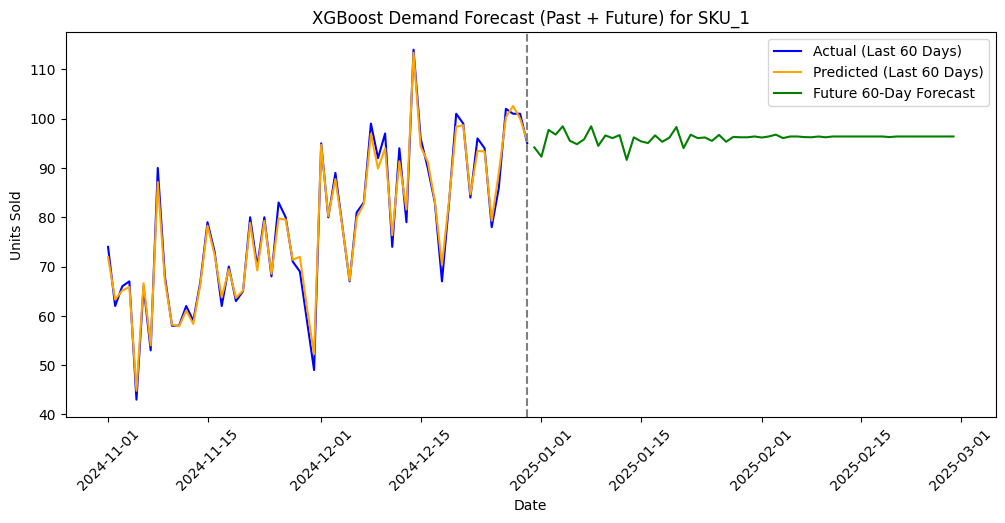

In [15]:
plt.figure(figsize=(12,5))

plt.plot(dates_last60, actual_last60, label="Actual (Last 60 Days)", color="blue")

plt.plot(dates_last60, pred_last60, label="Predicted (Last 60 Days)", color="orange")

plt.plot(future_dates, future_preds, label="Future 60-Day Forecast", color="green")

plt.axvline(dates_last60.iloc[-1], linestyle="--", color="gray")

plt.legend()
plt.xlabel("Date")
plt.ylabel("Units Sold")
plt.title(f"XGBoost Demand Forecast (Past + Future) for {sku}")
plt.xticks(rotation=45)
plt.show()

In [17]:
forecast_df = pd.DataFrame({
    "Date": future_dates,
    "Forecast_Demand": future_preds
})

forecast_df.to_csv("future_demand_forecast.csv", index=False)

print("Saved: future_demand_forecast.csv")


Saved: future_demand_forecast.csv


In [18]:
residuals_df = pd.DataFrame({
    "Residual": (y_test.values - pred)
})

residuals_df.to_csv("demand_residuals.csv", index=False)

print("Saved: demand_residuals.csv")


Saved: demand_residuals.csv


In [19]:
history_pred_df = pd.DataFrame({
    "Date": dates_last60,
    "Actual": actual_last60.values,
    "Predicted": pred_last60
})

history_pred_df.to_csv("last60_actual_vs_pred.csv", index=False)

print("Saved: last60_actual_vs_pred.csv")


Saved: last60_actual_vs_pred.csv
